# Integrantes
Gabriel Alves Reis - 2020006507 

Samuel Brísio Jesus - 2020085547

# Codigo

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [56]:

@jit(nopython=True) 
def create_mash(L):
    N = L**2
    lsing = np.random.rand(N)
    for i in range(N):
        lsing[i] = 1 if lsing[i] > 0.5 else -1
        
    return lsing

In [57]:
@jit(nopython=True)
def vizinhos(L):
    N = L ** 2
    #Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0): viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L: viz[k,3] = k+N-L
    return viz

In [58]:
@jit(nopython=True)
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [59]:
@jit(nopython=True)
def calc_energy(L, neighbors, S):
    N = L ** 2
    E = 0
    for i in range(N):
        h = S[neighbors[i, 0]] + S[neighbors[i, 1]]
        E -= S[i] * h 
    return E

# Metropolis

In [60]:
@jit(nopython=True)
def metropolis(T, S, neighbors, expoentes):
    for i in range (S.size):
        h = S[neighbors[i, 0]] + S[neighbors[i, 1]] + S[neighbors[i, 2]] + S[neighbors[i, 3]]
        r = np.random.rand()

        if r <= expoentes[int(h*S[i]*0.5 + 2)]:
            S[i] *= -1
    
    return S, neighbors
    

# Monte Carlo

In [61]:
@jit(nopython=True)
def Monte_Carlos(L, T, Steps : int):
    S = create_mash(L)
    neighbors = vizinhos(L)

    Energys = []
    Energys.append(calc_energy(L, neighbors, S))

    Magnetizacao = []
    Magnetizacao.append(S.sum())

    expoentes = expos(1/T)
    
    for i in range(Steps):
        S, neighbors =  metropolis(T, S, neighbors, expoentes)
        Energys.append(calc_energy(L, neighbors, S))
        Magnetizacao.append(S.sum())
    
    return Energys, Magnetizacao

In [62]:
def statistic_err(Arr):
    return np.sqrt(((Arr - Arr.mean())**2).sum()/(Arr.size*(Arr.size - 1)))


In [63]:
def Monte_Carlos_calc_and_print(L: int, T: int, N_passos, N_passos_ignorados, tamanho_do_bloco, n_bins):
    np.random.seed(0)
    energia, magnetizacao = Monte_Carlos(L, T, N_passos)
    energy = energia[N_passos_ignorados:]
    mags = magnetizacao[N_passos_ignorados:]

    n_blocos = (N_passos - N_passos_ignorados) // tamanho_do_bloco

    calor_esp = np.empty(n_blocos)
    sucep_mag = np.empty(n_blocos)
    spin_energy = np.empty(n_blocos)
    spin_mag = np.empty(n_blocos)

    for i in range(n_blocos):
        E = np.asarray((energy[i*tamanho_do_bloco:(i+1)*tamanho_do_bloco]))
        beta = 1 / T
        calor_esp[i] = (beta**2/tamanho_do_bloco) * ((E**2).mean() - (E.mean())**2)

        M = np.asarray((mags[i*tamanho_do_bloco:(i+1)*tamanho_do_bloco]))
        sucep_mag[i] = (beta/tamanho_do_bloco) *((M**2).mean() - (M.mean())**2)

        spin_energy[i] = E.mean() / L**2
        spin_mag[i] = M.mean() / L**2
    
    returnMatrix = np.zeros((4, 2))
    returnMatrix[:, 0] = np.array([calor_esp.mean(), sucep_mag.mean(), spin_energy.mean(), spin_mag.mean()])
    returnMatrix[:, 1] = np.array([statistic_err(calor_esp), statistic_err(sucep_mag), statistic_err(spin_energy), statistic_err(spin_mag)])

    return returnMatrix

# Execucao

## Variando a temperatura

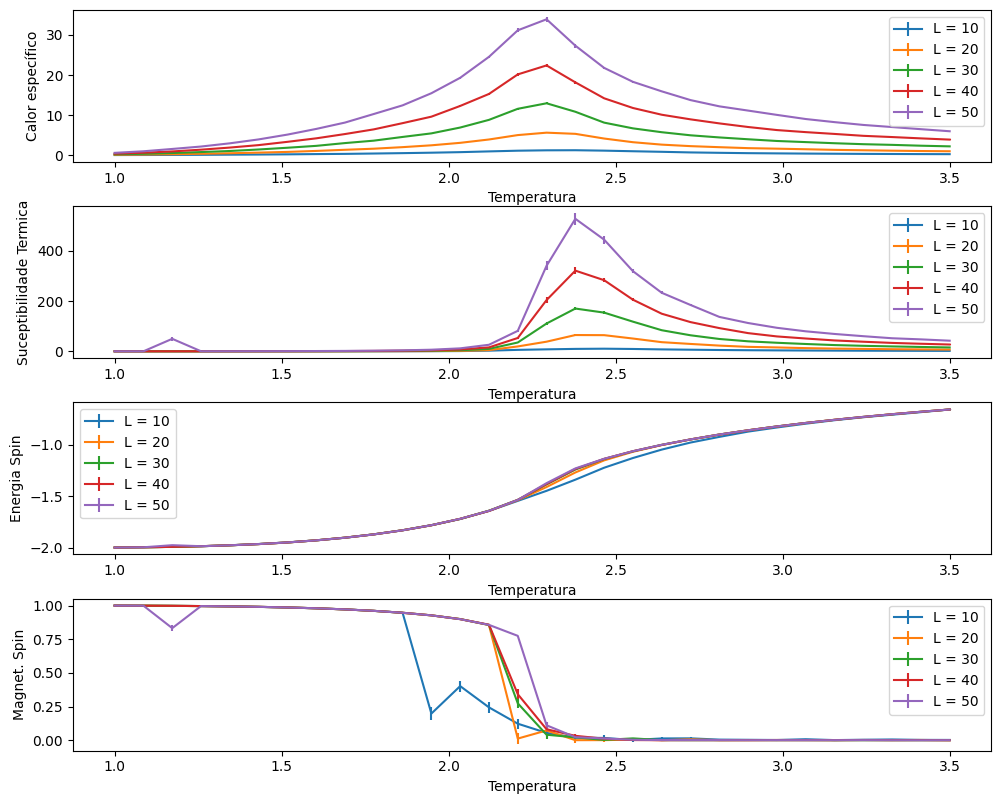

In [64]:
bins = 30
temperaturas = np.linspace(1, 3.5, bins)
tamanhos = [10, 20, 30, 40, 50]
calor_especifico = np.zeros((bins, 2))
sucep_termic = np.zeros((bins, 2))
energ_spin = np.zeros((bins, 2))
magnet_spin = np.zeros((bins, 2))

picoSucep = (0, 0)
picoCalorEsp = (0, 0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
fig.tight_layout()
for tamanho in tamanhos:
    i = 0
    for temperatura in temperaturas:
        info_termodinamica = Monte_Carlos_calc_and_print(tamanho, temperatura, 42000, 2001, 100, 60)
        calor_especifico[i, :] = info_termodinamica[0, :]
        sucep_termic[i, :] = info_termodinamica[1, :]
        energ_spin[i, :] = info_termodinamica[2, :]
        magnet_spin[i, :] = info_termodinamica[3, :]

        picoCalorEsp = picoCalorEsp if calor_especifico[i][0] <= picoCalorEsp[1] else (temperatura, calor_especifico[i][0])
        picoSucep = picoSucep if sucep_termic[i][0] <= picoSucep[1] else (temperatura, sucep_termic[i][0])
        i += 1


    ax1.errorbar(temperaturas, calor_especifico[:, 0], yerr=calor_especifico[:, 1], label= f"L = {tamanho}")

    ax2.errorbar(temperaturas, sucep_termic[:, 0], yerr=sucep_termic[:, 1], label= f"L = {tamanho}")

    ax3.errorbar(temperaturas, energ_spin[:, 0], yerr=energ_spin[:, 1], label= f"L = {tamanho}")

    ax4.errorbar(temperaturas, np.abs(magnet_spin[:, 0]), yerr=magnet_spin[:, 1], label= f"L = {tamanho}")

ax1.set_ylabel('Calor específico')
ax2.set_ylabel('Suceptibilidade Termica')
ax3.set_ylabel('Energia Spin')
ax4.set_ylabel('Magnet. Spin')

ax1.set_xlabel('Temperatura')
ax2.set_xlabel('Temperatura')
ax3.set_xlabel('Temperatura')
ax4.set_xlabel('Temperatura')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

# Atividade


1 - Decidimos o número de passos Monte Carlo de forma empírica realizamos 42.000 passos e descartamos os 2.000 primeiros, esta decisão foi feita com base no exercício anterior que mostrou que os sistemas convergiam depois de 2.000 passos.

2 - Em relação ao Calor Específico percebemos que há um pico para um valor de temperatura próximo de 2.25, algo similar a uma distribuição normal.
Algo similar acontece com a Suceptibilidade Térmica, no entanto o pico fica entorno de 2.27 e para temperaturas menores que 1.75 a suceptibilidade mostra-se nula.
Para a Energia do Spin, a curva assemelha-se com a curva logística estabilizando em, aproximadamente, -0.5.
Por último, a Magnetização do Spin estabiliza-se em 1 para valores de temperatura menores que 1.75 e em 0 para valores maiores que 2.75.

3 - O comportamento aparenta ser comum entre os tamanhos para os seguintes casos:
    - Calor Específico para temperaturas abaixo de 0.8
    - Suceptibilidade Térmica para valroes abaixo de 1.75
    - Energia do Spin para temperaturas maiores que 1
    - Magnetização do Spin para valores entre 1 e 1.75 e maiores que 2.75

4 - Como é o comportamento dos erros estatísticos à medida que a temperatura varia? 
    Tem algum valor de temperatura em torno do qual os erros são maiores?
    Você enxerga algum motivo para isso? 
    Os erros estatísticos dependem do tamanho do sistema?
    Como? -> falta responder isso

    A análise da nossa implementação mostra que os erros estátisticos foram bem pequenos durante os experimentos, porém quando a temperatura se aproximava de 2.3 o erro estátisco apresentou valores significantes que aumentava conforme o tamanho do nosso sistema. A explicação que demos para esse comportamento foi que há uma transição de fase em algum ponto proximo de 2.3.
    

5 - 
    Fase Paramagnética: Nessa fase, os spins são orientados de forma aleatória. Em altas temperaturas, a fase paramagnética é a fase dominante, e a magnetização média do sistema
    tende a zero. Fase Ferromagnética: Nessa fase, todos os spins estão alinhados na mesma direção. Essa fase ocorre em baixas temperaturas.

6 - Para estimar a temperatura de mudança de fase realizamos a média entre os picos de calor específico e suceptibilidade térmica resultando em 2.33 .



